In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_variants_df = pd.read_csv("./data/training_variants")
test_variants_df = pd.read_csv("./data/test_variants")
train_text_df = pd.read_csv("./data/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv("./data/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

train_full = train_variants_df.merge(train_text_df, how='inner', on='ID')

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


Use TF-IDF to Vectorize the texts. 

In [4]:
tfidf = TfidfVectorizer(
    min_df=1, max_features=16000, strip_accents='unicode',lowercase =True,
    analyzer='word', use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(train_full["Text"])

Xtr = tfidf.fit_transform(train_full["Text"])
features = tfidf.get_feature_names()

To get some feeling of what's in the texts.

In [4]:
row = np.squeeze(Xtr[4].toarray())
top_id = np.argsort(row)[-100:]
for i in top_id:
    print(row[i])
    print(features[i])

0.0417689453172
mutations
0.0418947957314
egf
0.042485870467
orthovanadate
0.0426482605304
ring
0.042742774261
bridges
0.0428471596207
rmsd
0.0429524982845
waals
0.0429524982845
thirds
0.043427495395
sc
0.0434919723361
homozygous
0.0435497118479
force
0.0438317430994
monomeric
0.0442385435712
piscataway
0.0442524229757
affinity
0.0444234961089
benign
0.044632504757
balance
0.045017658653
recurrent
0.0455528340324
biorad
0.0456193155048
equation
0.045821090391
repaired
0.0458597079587
s5
0.0458891407567
ub
0.0459746278225
salt
0.0463074382842
unphosphorylated
0.0464566297973
interface
0.0466133803989
cosmic
0.0468123936506
server
0.0469612280192
duplicated
0.047330328376
neutral
0.0474196129801
fitness
0.0474367057272
nj
0.0479784871671
constituted
0.0482265505671
optimization
0.0482409768465
structures
0.0486522263092
2x
0.0488944603765
id
0.0493562170444
pdb
0.0495538181572
donkey
0.0503295392068
belonged
0.0505319041083
blind
0.0506806643127
state
0.0507196245027
thermodynamic
0.0514

Use Rocchio(NearestCentroid) classification. I didn't split training/test here. Just want to see what accuracy 
Rocchio can get using the training data itself. Turns out this is a high bias algorithm.

In [6]:
from sklearn.neighbors.nearest_centroid import NearestCentroid


y = train_full["Class"]
clf = NearestCentroid()
clf.fit(Xtr, y)
print(clf.score(Xtr, y))
y_pred = clf.predict(Xtr)
centroids = clf.centroids_

0.599217103282


Computing log-loss of the TF-IDF classification here

In [7]:
def predict(X, ctr):
    p = np.zeros((X.shape[0], 9))
    for n in range(X.shape[0]):
        d = np.zeros(9)
        for i in range(9):
            d[i] = np.linalg.norm(X[n,:] - ctr[i,:])
        d = d/np.linalg.norm(d)
        p[n,:] = d
    return p

def onehot(y):
    output = np.zeros((len(y), 9))
    for i,n in enumerate(y):
        output[i,n-1]=1
    return output

def logloss(y, X):
    N = X.shape[0]
    x = 0
    for i in range(N):
        x+= np.dot(y[i,:], np.log2(X[i,:]))
    x = (-1./N)*x
    return x
print('Log-loss of TF-IDF prediction')
print(logloss(onehot(y_tr), output))

Log-loss of TF-IDF prediction


NameError: name 'y_tr' is not defined

Normalized confusion matrix
[[ 0.67  0.04  0.    0.06  0.11  0.02  0.09  0.01  0.  ]
 [ 0.04  0.66  0.01  0.02  0.    0.    0.25  0.01  0.  ]
 [ 0.09  0.09  0.52  0.08  0.1   0.01  0.11  0.    0.  ]
 [ 0.29  0.03  0.01  0.47  0.07  0.02  0.1   0.01  0.  ]
 [ 0.13  0.04  0.04  0.06  0.45  0.06  0.18  0.03  0.  ]
 [ 0.16  0.07  0.01  0.03  0.08  0.48  0.17  0.    0.  ]
 [ 0.02  0.22  0.04  0.01  0.01  0.    0.69  0.01  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.16  0.79  0.05]
 [ 0.05  0.03  0.    0.03  0.    0.    0.    0.16  0.73]]


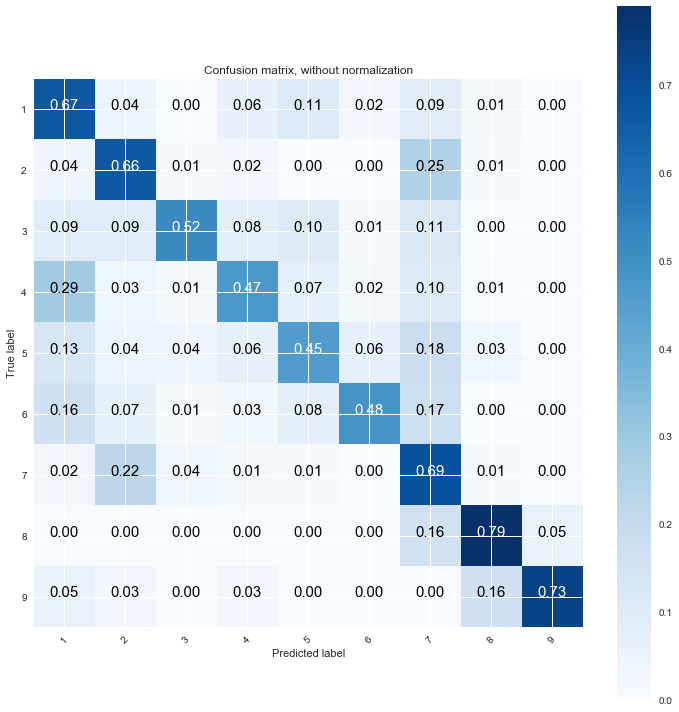

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center", fontsize = 15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=range(1,10), normalize=True, 
                      title='Confusion matrix, without normalization')
plt.show()

It seems it is easy to predict a class-4 text into class-1, and it's hard to distinguish class-2 and class-7